In [3]:
import torch
from torchvision import models
import numpy as np
from PIL import Image
from pathlib import Path
from torchvision import transforms as T
from experiments.dataset import Focus
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import torch.nn.functional as F
from matplotlib import rc
from robustness.model_utils import make_and_restore_model
from robustness.datasets import ImageNet
rc('text', usetex=True)

In [6]:
# model = models.resnet50(pretrained=True)
# ckpt = torch.load("/cmlscratch/pkattaki/void/bg-var/logs/robust_resnet/imagenet_l2_3_0.pt")
# model.load_state_dict(ckpt["model"])

# print(ckpt.keys())

model = make_and_restore_model(arch="resnet50",
                                  dataset=ImageNet("/fs/cml-datasets/ImageNet/ILSVRC2012"),
                                  resume_path="/cmlscratch/pkattaki/void/bg-var/logs/robust_resnet/imagenet_l2_3_0.pt",
                                  )[0].model
model.eval()

=> loading checkpoint '/cmlscratch/pkattaki/void/bg-var/logs/robust_resnet/imagenet_l2_3_0.pt'
=> loaded checkpoint '/cmlscratch/pkattaki/void/bg-var/logs/robust_resnet/imagenet_l2_3_0.pt' (epoch 105)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): SequentialWithArgs(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), str

In [7]:
activation = {}
# def activation_hook(model, input, output):
#     activations = output / torch.norm(output, dim=1, p=2, keepdim=True)
#     activations = activations / np.sqrt(1.0 * activations.shape[2] * activations.shape[3])
#     activation["activations"] = activations
    
def feature_hook(model, input, output):
    activation["features"] = output
    
    
# model.layer4[-1].register_forward_hook(activation_hook)
model.avgpool.register_forward_hook(feature_hook)
model.cuda()
W = model.fc.weight
b = model.fc.bias
print(W.shape, b.shape)

torch.Size([1000, 2048]) torch.Size([1000])


In [8]:
predictions = np.load("../../logs/resnet/predictions.npy")
bg_var_root = Path("/cmlscratch/pkattaki/datasets/bg-var")
dataset = Focus(
    bg_var_root,
    categories=[
    "truck",
    "car",
    "plane",
    "ship",
    "cat",
    "dog",
    "horse",
    "frog",
    "deer",
    "bird",
    ],
    times=None,
    weathers=None,
    locations=None,
    transform=None
)
test_transform = T.Compose(
    [
        T.Resize(224),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [9]:
common_images = []
uncommon_images = []
for idx in range(predictions.shape[0]):
    prediction = predictions[idx]
    if prediction[2] == 1 and prediction[-5] == prediction[-4] == prediction[-3] == 0:
        common_images.append(idx)
    if prediction[2] == 1 and prediction[-3] == 1:
        uncommon_images.append(idx)

common_images = [dataset.image_files[idx][0][1:] for idx in common_images]
uncommon_images = [dataset.image_files[idx][0][1:] for idx in uncommon_images]
print(len(common_images), len(uncommon_images))


966 850


In [17]:
with torch.no_grad():
    size_per_batch = 150
    common_batch = torch.stack([test_transform(Image.open(bg_var_root / f).convert("RGB")) for f in common_images[:size_per_batch]]).to("cuda")
    uncommon_batch = torch.stack([test_transform(Image.open(bg_var_root / f).convert("RGB")) for f in uncommon_images[:size_per_batch]]).to("cuda")
    logits = model(common_batch)
    max_logits = torch.zeros(2 * size_per_batch)
    max_logits[:size_per_batch], ps = torch.max(F.softmax(logits, dim=1), 1)
#     max_logits[:size_per_batch], _ = torch.max(F.softmax(logits, dim=1)[:, [404, 895]], 1)

    mat = torch.zeros(2 * size_per_batch, 2048)
    common_features = activation["features"]
    similarities = torch.zeros(2 * size_per_batch)
        
    
    for idx, (c, p) in enumerate(zip(common_features, ps)):
        mat[idx] = torch.flatten(c)
        w = torch.cat((W[p], b[p:p+1])).cpu()
#         w_t_1 = torch.cat((W[404], b[404:404+1])).cpu()
#         w_t_2 = torch.cat((W[895], b[895:895+1])).cpu()
        feature = torch.cat((torch.flatten(c.cpu()), torch.ones(1)))
        similarities[idx] = F.cosine_similarity(feature, w, dim=0)
#         similarities[idx] = torch.max(F.cosine_similarity(feature, w_t_1, dim=0), F.cosine_similarity(feature, w_t_2, dim=0))

    # mat = torch.zeros(64, common_activations.shape[-1])
    # mat[:32] = common_activations

    logits = model(uncommon_batch)
    max_logits[size_per_batch:], ps = torch.max(F.softmax(logits, dim=1), 1)
#     max_logits[size_per_batch:], _ = torch.max(F.softmax(logits, dim=1)[:, [404, 895]], 1)
#     uncommon_activations = activation["activations"]
    uncommon_features = activation["features"]

    for idx, (c, p) in enumerate(zip(uncommon_features, ps)):
        mat[idx + size_per_batch] = torch.flatten(c)
        w = torch.cat((W[p], b[p:p+1])).cpu()
        feature = torch.cat((torch.flatten(c.cpu()), torch.ones(1)))
        similarities[idx + size_per_batch] = F.cosine_similarity(feature, w, dim=0)
#         similarities[idx + size_per_batch] = torch.max(F.cosine_similarity(feature, w_t_1, dim=0), F.cosine_similarity(feature, w_t_2, dim=0))
mat = mat.detach().cpu().numpy()
similarities = similarities.detach().cpu().numpy()
max_logits = max_logits.detach().cpu().numpy()

In [24]:
norms = np.sum(mat ** 2, axis=1, keepdims=True)
distances = norms - 2 * mat @ mat.T + norms.T
common_distances = []
uncommon_distances = []
inter_distances = []
for i in range(size_per_batch):
    for j in range(i + 1, size_per_batch):
        common_distances.append(distances[i, j])

for i in range(size_per_batch - 1):
    for j in range(size_per_batch + i, 2 * size_per_batch):
        inter_distances.append(distances[i, j])
        
for i in range(size_per_batch, 2 * size_per_batch):
    for j in range(i + 1, 2 * size_per_batch):
        uncommon_distances.append(distances[i, j])
common_distances = np.array(common_distances)
uncommon_distances = np.array(uncommon_distances)
inter_distances = np.array(inter_distances)

In [25]:
print(uncommon_distances.shape, common_distances.shape, inter_distances.shape)

(11175,) (11175,) (11324,)


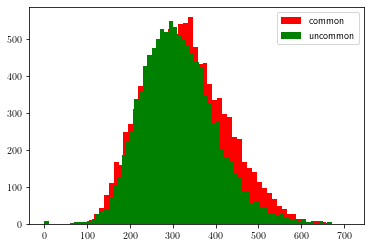

In [27]:
%matplotlib inline
plt.hist(common_distances, bins="auto", facecolor='r', label="common")
plt.hist(uncommon_distances, bins="auto", facecolor='g', label="uncommon")
# plt.hist(inter_distances, bins="auto", facecolor='b', label="inter")
plt.legend(loc="upper right")
plt.show()

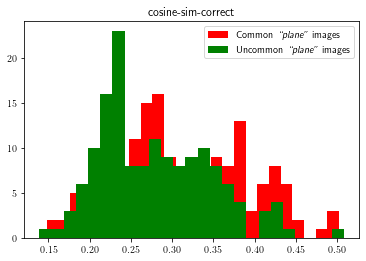

In [21]:
# %matplotlib inline
plt.hist(similarities[:size_per_batch], bins=25, facecolor='r', label=r"Common \textit{``plane''} images")
plt.hist(similarities[size_per_batch:], bins=25, facecolor='g', label=r"Uncommon \textit{``plane''} images")
# plt.hist(inter_distances, bins="auto", facecolor='b', label="inter")
plt.legend(loc="upper right")
# plt.gcf().savefig("cos-sim-plane.pdf")
# plt.title("cosine-sim-correct")
plt.show()

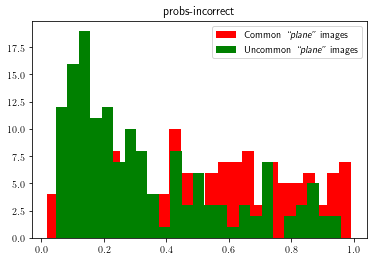

In [23]:
# %matplotlib inline
plt.hist(max_logits[:size_per_batch], bins=25, facecolor='r', label=r"Common \textit{``plane''} images")
plt.hist(max_logits[size_per_batch:], bins=25, facecolor='g', label=r"Uncommon \textit{``plane''} images")
# plt.hist(max_logits[size_per_batch:], bins=25, facecolor='g', label=r"Uncommon \textit{``plane''} images")
# plt.hist(inter_distances, bins="auto", facecolor='b', label="inter")
plt.legend(loc="upper right")
# plt.gcf().savefig("cos-sim-plane.pdf")
plt.show()

In [ ]:
similarities[:10]